## EN2550: Assignment 03 on Object Counting on a Conveyor Belt 
**Name** - Rajapaksha R.M.P.A.P. 

**Index No** - 190484T 

**Github Repo** - https://github.com/rajapaksha-rmpap/EN2550-Assignment-3-190484T.git 
### **Connected Component Analysis** 
In this part, we will generate an indexed image representing connected components in `conveyor_f101.png` image. Notice that, as there are three square nuts and one hexagonal nut in the image, there will be five connected components (backgound will be assigned the label 0). 

1. Open the `hexnut_template.png`, `squarenut_template.png` and `conveyor_f100.png` and display. 

In [1]:
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

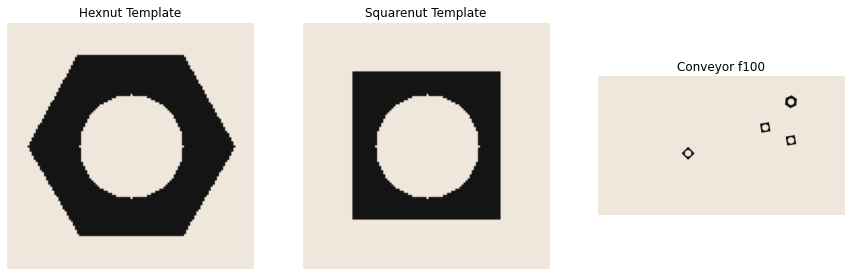

In [2]:
hexnut_template = cv.imread('hexnut_template.png', cv.IMREAD_COLOR)
squarenut_template =  cv.imread('squarenut_template.png', cv.IMREAD_COLOR)
conveyor_f100 =  cv.imread('conveyor_f100.png', cv.IMREAD_COLOR)

fig, ax = plt. subplots(1,3, figsize = (15, 5))
ax[0].imshow(cv.cvtColor(hexnut_template, cv.COLOR_RGB2BGR)); ax[0].axis('off'); ax[0].set_title("Hexnut Template") 
ax[1].imshow(cv.cvtColor(squarenut_template, cv.COLOR_RGB2BGR)); ax[1].axis('off'); ax[1].set_title("Squarenut Template") 
ax[2].imshow(cv.cvtColor(conveyor_f100, cv.COLOR_RGB2BGR)); ax[2].axis('off'); ax[2].set_title("Conveyor f100") 
plt.show() 

2. Convert the images to grayscale and apply **Otsu's thresholding** to obtain the binarized image. Do this for both the templates and belt images. See https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html for a guide. State the threshold value (automatically) selected in the operation. Display the output images. 

    **Problem Discussion** - 
    > Otsu's Thresholding is similar to simple binary thresholding, however, instead of giving the threshold value manually, Otsu's Thresholding calculates a suitable threshold value automatically, such that the two pixel value distributions seperated by the threshold will have the minimum standard variation values. 

In [3]:
def variance(start, end, hist): 
    "calculate the variance of the pixel value distribution from start index to end index" 
    if start == end: return 0 
    count = np.sum(hist[start:end]) 
    mean = np.sum([pixel_val * hist[pixel_val] for pixel_val in range(start, end)]) / count 
    var = np.sum([(pixel_val - mean)**2 * hist[pixel_val] for pixel_val in range(start, end)]) 
    return var 

def OtsuThresholding(img): 
    "perform Otsu's Thresholding on a given image" 
    # step 1 - convert the color img into a grayscale img 
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 

    # step 2 - finding the histogram of the grayscale img 
    hist = cv.calcHist([img], [0], None, [256], [0, 256]) 

    # step 3 - calculating the threshold value 
    min_total_var = np.inf 
    threshold = -1 
    for i in range(1, 256): 
        total_var = variance(0, i, hist) + variance(i, 256, hist) 
        if (total_var < min_total_var): 
            min_total_var = total_var
            threshold = i 
    # step 4 - verifying the threshold value 
    cv_threshold, img_ = cv.threshold(img, 127, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    print("threshold = %d, automatic threshold = %g" %(threshold, cv_threshold)) 

    # step 5 - performing simple thresholding 
    threshold, thresholded_img = cv.threshold(img, threshold, 255, cv.THRESH_BINARY_INV) 
    return thresholded_img 

C:\Users\HI\AppData\Local\Temp/ipykernel_8468/2049372574.py:5: RuntimeWarning: invalid value encountered in float_scalars
  mean = np.sum([pixel_val * hist[pixel_val] for pixel_val in range(start, end)]) / count


threshold = 21, automatic threshold = 20
threshold = 21, automatic threshold = 20
threshold = 21, automatic threshold = 20


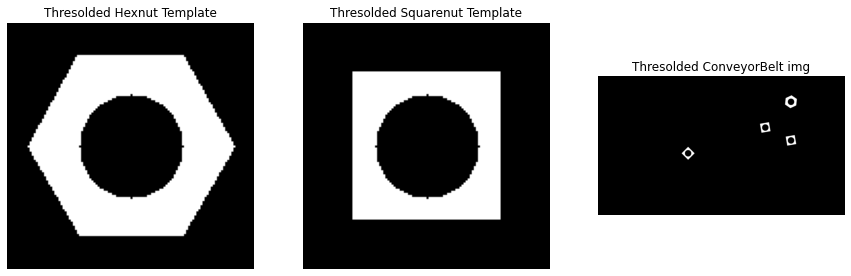

In [4]:
imgs = [OtsuThresholding(hexnut_template), OtsuThresholding(squarenut_template), OtsuThresholding(conveyor_f100)] 
titles = ["Thresolded Hexnut Template", "Thresolded Squarenut Template", "Thresolded ConveyorBelt img"] 

fig, ax = plt.subplots(1, len(imgs), figsize = (15, 5))
for i in range(len(imgs)): 
    ax[i].imshow(imgs[i], cmap='gray'); ax[i].axis('off'); ax[i].set_title(titles[i]) 

3. Carry out **morphological closing** to remove small holes inside the foreground. Use a 3×3 kernel. See https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html for a guide. 

    **Problem Discussion** - 
    > - Notice that, here in this images, ***the foreground is in white and the background is in black***. 
    > - Therefore, to remove the black holes in the white foreground, we have to perform ***morphological closing; firstly dilation then erosion***. 
    > - In morphological closing, the first dilation operation will enlargen the white colored regions, thus removing the black spots/holes in the white foreground. Then, the second erosion operation will recover black background regions covered by white after dilation. 
    > - In this manner, we can remove the black noises in the white foreground, while keeping the foreground and background areas mostly unchanged. 

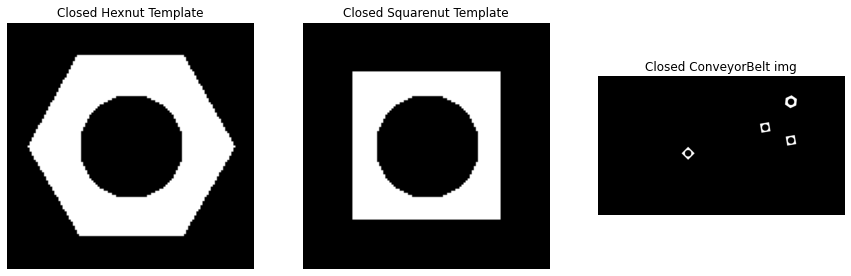

In [5]:
kernel = np.ones((3, 3), dtype=np.uint8) 
closed_imgs = [] 
for img in imgs: 
    closed_img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) # performing morphographical opening on images 
    closed_imgs.append(closed_img) 
titles = ["Closed Hexnut Template", "Closed Squarenut Template", "Closed ConveyorBelt img"] 

fig, ax = plt.subplots(1, len(closed_imgs), figsize = (15, 5))
for i in range(len(closed_imgs)): 
    ax[i].imshow(closed_imgs[i], cmap='gray'); ax[i].axis('off'); ax[i].set_title(titles[i]) 

4. Connected components analysis: apply the connectedComponentsWithStats function (see https://docs.opencv.org/4.5.5/d3/dc0/group__imgproc__shape.html#ga107a78bf7cd25dec05fb4dfc5c9e765f) and display the outputs as colormapped images. 

Text(0.5, 1.0, 'Connected Components in ConveyorBelt img')

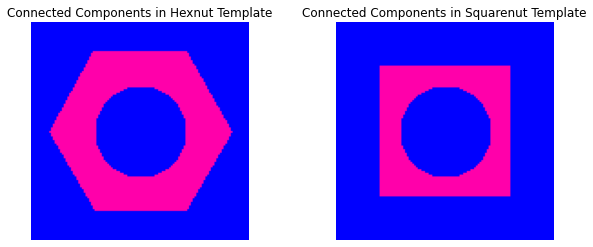

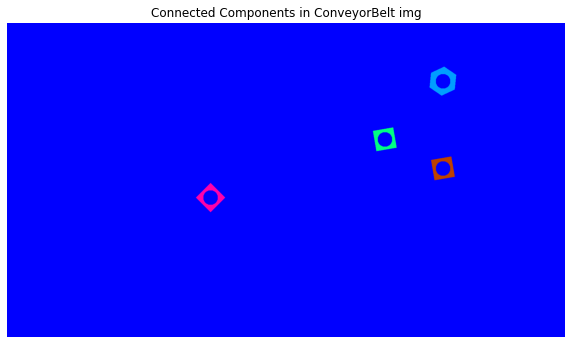

In [7]:
# connected component analysis 
colormapped_imgs = [] 
info = [] 
for i, img in enumerate(closed_imgs): 
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(img) 
    colormapped_img = cv.applyColorMap((labels/np.amax(labels) * 255).astype(np.uint8), cv.COLORMAP_RAINBOW) 
    colormapped_imgs.append(colormapped_img) 
    info.append([retval, labels, stats, centroids])

titles = ["Connected Components in Hexnut Template", "Connected Components in Squarenut Template", "Connected Components in ConveyorBelt img"] 
fig1, ax1 = plt.subplots(1, 2, figsize = (10, 4)) 
ax1[0].imshow(colormapped_imgs[0]); ax1[0].axis('off'); ax1[0].set_title(titles[0]) 
ax1[1].imshow(colormapped_imgs[1]); ax1[1].axis('off'); ax1[1].set_title(titles[1]) 
fig2, ax2 = plt.subplots(1, 1, figsize = (10, 6)) 
ax2.imshow(colormapped_imgs[2]); ax2.axis('off'); ax2.set_title(titles[2]) 

* ##### How many connected components are detected in each image? 
> - In each of the hexnut and squarenut templates, we have two connected components; (black) background (label=0) and foreground/object (label = 1). 
> - There are 5 connected components in the conveyor-belt image; background, 1 hexnut, and 3 squarenuts. 

In [72]:
for i in range(len(colormapped_imgs)): 
    retval = info[i][0] 
    print("for the", titles[i].split()[3], "image \n     no.of connected components =", retval) 

for the Hexnut image 
     no.of connected components = 2
for the Squarenut image 
     no.of connected components = 2
for the ConveyorBelt image 
     no.of connected components = 5


- ##### What are the statistics? Interpret these statistics. 
> * 'statistics' is a 2D array where each row corresponds to one connected component in the image. 
> * There are 5 statistics values in each row. 
> * The first two values are the coordinates (x, y) of the top-left corner of the bounding box of the object. 
> * The third and fourth values show the width (along x-axis) and height (along y-axis) of the bounding box respectively. 
> * The fifth or last value is the area of the connected component given in pixels. 

Let us verify the area of the hexnut as mentioned in the problem. (For the hexnut template, you should get the object area in pixel as approximately 4728.)

In [73]:
hexnut_info = info[0] 
hexnut_stats = hexnut_info[2] 
area = hexnut_stats[1][4] 
print("area of the hexnut object = %d" %area)

area of the hexnut object = 4728


- ##### What are the centroids? 
> * centroid of a connected component is the centroid/center of the object which is obtained by treating each pixel as equally weighted points. 

Let us carry out a manual calculation and verify the solution. 

In [83]:
# consider the hexnut object 
hexnut = info[0][1] 
height, width = hexnut_template.shape[:2] 
centroid_x = np.sum(hexnut * np.arange(0, width, 1)) / area 
centroid_y = np.sum(hexnut.T * np.arange(0, height, 1)) / area 
print("manually calculated centroid = [%f, %f]" %(centroid_x, centroid_y)) 
print("centroid given by opencv =", info[0][3][1]) 

manually calculated centroid = [59.833756, 59.223562]
centroid given by opencv = [59.83375635 59.22356176]


5. Contour analysis: Use findContours function to retrieve the extreme outer contours. (see https://docs.opencv.org/4.5.2/d4/d73/tutorial_py_contours_begin.html for help and https://docs.opencv.org/4.5.2/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0 for information.
Display these contours. 

Text(0.5, 1.0, 'Extreme Outter Contours in conveyor-belt image')

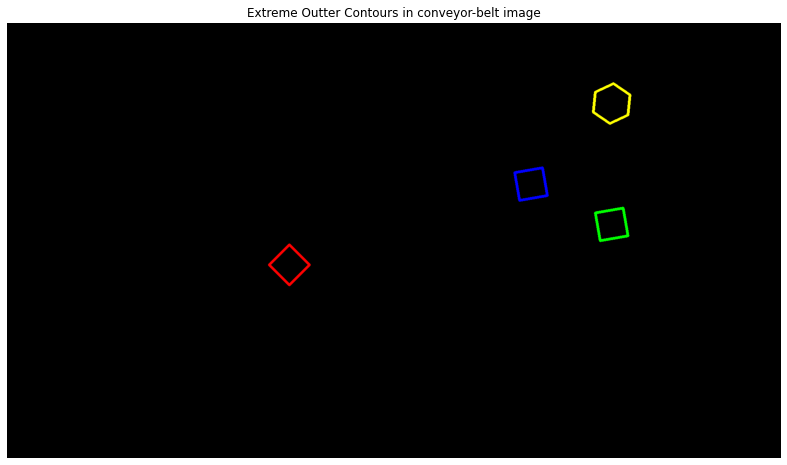

In [6]:
# finding all contours in the Conveyor-belt image
conveyorbelt_img = closed_imgs[2] 
contours, hierarchy = cv.findContours(conveyorbelt_img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) 

# there are total of 8 contours detected; 4 inner and 4 outter contours 
# the outter contours have the indices 0, 2, 4, 6
outter_contours = [contours[i] for i in (0, 2, 4, 6)] 

# creating a black image with the same shape as the conveyor_f100 img 
black = np.zeros(conveyor_f100.shape).astype(np.uint8) 

# creating 4 RGB colors; red, green, blue, yellow 
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)] 

for i, c in enumerate(outter_contours): 
    cv.drawContours(black, [c], -1, colors[i], 5) 

fig, ax = plt.subplots(figsize = (16, 8)) 
ax.imshow(black); ax.axis('off'); ax.set_title("Extreme Outter Contours in conveyor-belt image") 

### **Detecting Objects on a Synthetic Conveyor**
In this section, we will use the synthetic conveyor.mp4 sequence to count the two types of nuts.

1. Open the sequence and play it using the code below.

In [85]:
cv.namedWindow('Conveyor', cv.WINDOW_NORMAL)
cap = cv.VideoCapture('conveyor.mp4')
f = 0
frame = []      
while cap.isOpened():                                    
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting.")
        break

    f += 1
    text = 'Frame:' + str(f)
    cv.putText(frame, text, (100, 100), cv.FONT_HERSHEY_COMPLEX, 1, (0,250,0), 1, cv.LINE_AA)
    cv.imshow('Conveyor', frame)

    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows() 

Can't receive frame (stream end?). Exiting.


1. Count the number of matching hexagonal nuts in conveyor_f100.png. You can use matchContours function as shown in https://docs.opencv.org/4.5.2/d5/d45/tutorial_py_contours_more_functions.html to match contours in each frame with that in th template.

Text(0.5, 1.0, 'contours in hexnut template')

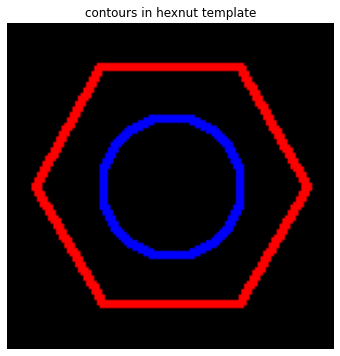

In [7]:
# taking the contours of the hexagonal nut from hexnut template 
hexnut_template_closed = closed_imgs[0] 
hexnut_contours, hexnut_hierarchy = cv.findContours(hexnut_template_closed, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) 

# visulaizing the contours in hexnut template 
hexnut_black = np.zeros(hexnut_template.shape).astype(np.uint8) 
colors = ((255, 0, 0), (0, 0, 255)) # red, blue 
for i, c in enumerate(hexnut_contours): 
    cv.drawContours(hexnut_black, [c], -1, colors[i], 2) 
fig, ax = plt.subplots(figsize = (6, 6)) 
ax.imshow(hexnut_black); ax.axis('off'); ax.set_title("contours in hexnut template") 

* We can observe that the first (red) contour is the outter contour, which has the hexagonal shape that can be used to identify the hexnuts out from the other objects 
* Then, we will check the similarity between the hexnut outter contour and other contours in the `conveyor_f100` image, and visualize the results, thus we can find a threshold value to identify correct matches. 

In [8]:
hexnut_cnt = hexnut_contours[0] 
similarity = [] 
for c in contours: 
    result = cv.matchShapes(c, hexnut_cnt, 1, 0.0) 
    similarity.append(result) 
print(similarity) 

[0.026949348359551983, 0.005068897202343159, 0.027050230004169284, 0.005068897202963996, 0.027050230004169284, 0.005068897202467282, 8.228790019826349e-05, 0.005068897202932909]


* In the `conveyor_f100` image, the 7th contour (index=6) corresponds to the outter contour of the hexnut. And we can observe, for that match, the similarity metric is around $10^{-5}$ range, where all the other results are greater than $0.001$. 
* Therefore, we can use $0.001$ as a threshold to identify a correct hexnut match. A match will accepted as correct only if the comparison result is less than this threshold value. 

no of hexnuts = 1


Text(0.5, 1.0, 'Hexnuts in conveyor-belt image')

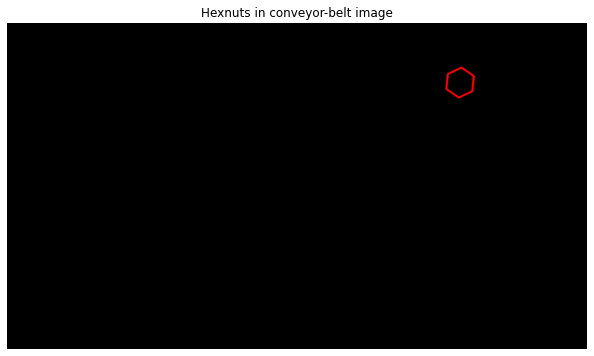

In [9]:
no_of_hexnuts = 0 
black = np.zeros(conveyor_f100.shape).astype(np.uint8) # empty black image 
for c in contours: 
    if (cv.matchShapes(c, hexnut_cnt, 1, 0.0) < 0.001): 
        no_of_hexnuts += 1; 
        cv.drawContours(black, [c], -1, (255, 0, 0), 6)
print("no of hexnuts = %d" %no_of_hexnuts) 

# visualizing the hexnuts in the conveyorbelt 
fig, ax = plt.subplots(figsize = (12, 6)) 
ax.imshow(black); ax.axis('off'); ax.set_title("Hexnuts in conveyor-belt image") 

2. Count the number of objects that were conveyed along the conveyor belt: Display the count in the current frame and total count upto the current frame in the output video. Please compress your video (using Handbreak or otherwise) before uploading. It would be good to experiment first with the two adjacent frames `conveyor_f100.png` and `conveyor_f101.png`. In order to disregard partially appearing nuts, consider comparing the contour area in addition to using the matchCountours function.

The algoirthm used here can be explained as follows. 
> We know that the initial frame of the video does not contain any objects (nuts). Therefore, counting the objects as they cross a checking line will do the work. 
> - **step 1 - consider a vertical line across the conveyor belt as the checking line** 
>> Here, we have considered a vertical pixel column goes through the middle of the frame as the reference/checking line to identify and count the objects. 
> - **step 2 - find the connected components in the frame** 
> - **step 3 - select the components that are crossing the reference line** 
>> This can be simply done by finding the component labels in the reference column. 
> - **step 4 - remove the previously considered objects** 
> - **step 5 - if there is a new component crossing the line, compare its contours for a hexnut or a squarenut** 

> The steps from 2 to 5 have to be repeated until the video frames end. 

In [10]:
# to find the squarenuts, we must have the outter contour of the square nut. 
squarenut_template_closed = closed_imgs[1] 
squarenut_contours, H = cv.findContours(squarenut_template_closed, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) 
squarenut_cnt = squarenut_contours[0] 
# we can verify that the same threshold value(0.001) works for the squarenut contour comparison too. 

In [11]:
def whatObject(img, label, stats): 
    "determines whether the given object specified by the label is a hexnut or a squarenut" 
    start_x, start_y, width, height = stats[label][:4] 
    obj_img = img[start_y: start_y+height][:, start_x: start_x+width] # creating the bounding box of the object 
    contours, hierarchy = cv.findContours(obj_img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE) 
    for c in contours: 
        if (cv.matchShapes(c, hexnut_cnt, 1, 0.0) < 0.001): return "Hexnut" 
        if (cv.matchShapes(c, squarenut_cnt, 1, 0.0) < 0.001): return "Squarenut" 
    return None 

In [12]:
cap = cv.VideoCapture('conveyor.mp4') 
f = 0 
frame_array = []
shape = (1080, 1920, 3)
hexnut_count = squarenut_count = 0 
pre_middle = np.array([0]) 

while True:                                    
    ret, frame = cap.read() 

    # finding the connected components in the frame 
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype(np.uint8) 
    thres, thresholded = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU) 
    kernel = np.ones((3, 3), dtype=np.uint8) 
    closed = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, kernel) 
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closed) 

    # finding the components crossing the reference line/checking line 
    mid_point = frame.shape[1] // 2 
    middle = labels[:, mid_point] # middle column 
    cv.line(frame, (mid_point, 0), (mid_point, frame.shape[0]-1), (0, 0, 255), 5) 
    crossing_objs = set(middle) # objects crossing the line 

    if middle.any(): # if there are any element crossing the checking line 
        # finding out previously considered objects 
        intersection = middle * pre_middle 
        intersection = (intersection != 0).astype(np.uint8) 
        pre_crossed_objs = set(middle * intersection) 

        # finding new objects entered the reference line  
        new_objs = crossing_objs - pre_crossed_objs 

        # finding the types of observed new objects 
        for obj in new_objs: 
            object = whatObject(closed, obj, stats)
            if object == "Hexnut": hexnut_count += 1 
            elif object == "Squarenut": squarenut_count += 1 
     
    pre_middle = middle 
    f += 1 
    if f > 379: break # remove the final frames, because they can be buggy 

    text = 'Frame:' + str(f) 
    retvalInfo = "Current Frame Count = " + str(retval-1) 
    hexInfo = "Hexnut Count = " + str(hexnut_count) 
    squareInfo = "Squarenut Count = " + str(squarenut_count) 
    Info = "Total Count = " + str(squarenut_count + hexnut_count) 
    cv.putText(frame, text, (100, 100), cv.FONT_HERSHEY_COMPLEX, 1, (0,250,0), 1, cv.LINE_AA) 
    cv.putText(frame, retvalInfo, (1400, 100), cv.FONT_HERSHEY_COMPLEX, 1, (0,250,0), 1, cv.LINE_AA) 
    cv.putText(frame, hexInfo, (1400, 200), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,250), 1, cv.LINE_AA) 
    cv.putText(frame, squareInfo, (1400, 275), cv.FONT_HERSHEY_COMPLEX, 1, (250,0,0), 1, cv.LINE_AA) 
    cv.putText(frame, Info, (1400, 350), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 1, cv.LINE_AA) 

    frame_array.append(frame) 

In [13]:
# writing the video
out = cv.VideoWriter('./conveyor_result_190484T.mp4', cv.VideoWriter_fourcc(*'h264'), 30, (shape[1], shape[0]))

for i in range(len(frame_array)):
    # cv.imshow('Frame', frame_array[i])
    out.write(frame_array[i])

out.release() 